In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

Process Process-13:
Process Process-12:
Process Process-11:
Process Process-1:
Process Process-9:
Process Process-8:
Process Process-14:
Process Process-7:
Traceback (most recent call last):
Process Process-3:
Traceback (most recent call last):
Process Process-2:
Process Process-16:
Traceback (most recent call last):
Process Process-10:
Traceback (most recent call last):
Process Process-15:
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-6:
Process Process-5:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/noa/Desktop/walker-2d/multiprocessing_env.py", line 11, in worker
    cmd, data = remote.recv()
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
KeyboardInterrupt
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/noa/anaconda3/envs/dml/lib/python3.7/multiprocessing/connection.py", line 407, in _recv

<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Tanh(),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
"""
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward
"""

'\ndef test_env(vis=False):\n    state = env.reset()\n    if vis: env.render()\n    done = False\n    total_reward = 0\n    while not done:\n        state = torch.FloatTensor(state).unsqueeze(0).to(device)\n        dist, _ = model(state)\n        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])\n        state = next_state\n        if vis: env.render()\n        total_reward += reward\n    return total_reward\n'

<h2>GAE</h2>

In [7]:
"""
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

# Calculate the generalized advantage estimation
def calculate_gae(tau, time_horizon, gamma, advantages):
    gaes = []
    prev_gae = []

    # Start with the last sample and move backwards 
    for i in range(time_horizon, 0, -1):
        advantage = rewards[i] + gamma*state_values[i]*terminal_state[i] - next_state_values[i]
"""

'\ndef compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):\n    values = values + [next_value]\n    gae = 0\n    returns = []\n    for step in reversed(range(len(rewards))):\n        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]\n        gae = delta + gamma * tau * masks[step] * gae\n        returns.insert(0, gae + values[step])\n    return returns\n\n# Calculate the generalized advantage estimation\ndef calculate_gae(tau, time_horizon, gamma, advantages):\n    gaes = []\n    prev_gae = []\n\n    # Start with the last sample and move backwards \n    for i in range(time_horizon, 0, -1):\n        advantage = rewards[i] + gamma*state_values[i]*terminal_state[i] - next_state_values[i]\n'

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [7]:
"""
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
"""

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            
            entropy_coefficient = 0.001
            distance,value = model(state)
            # Calculating the entropy for the yielded distance
            entropy = distance.entropy().mean()
            new_log_probs = distance.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            clipped_objective  = - torch.min(ratio*advantage, torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage)
            critic_loss = (return_ - value).pow(2)
            critic_mean_loss = critic_loss.mean()
            actor_mean_loss = clipped_objective.mean()
            loss = 0.5 * critic_mean_loss + actor_mean_loss - entropy_coefficient * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [8]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20*16
mini_batch_size  = 5
ppo_epochs       = 4
discount_factor = 0.99
lambda_ = 0.95

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
time_steps_to_train_for = 10**6
evaluate_every = 10**3
test_rewards = []

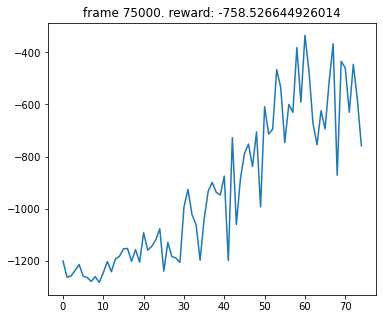

KeyboardInterrupt: 

In [11]:
state = envs.reset()
time_step_counter = 0



for time_step in range(time_steps_to_train_for):

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    terminal_states     = []
    entropy = 0

    for step_counter in range(num_steps):
        time_step_counter+=1
        
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        terminal_states.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        
        if time_step_counter % evaluate_every == 0:
            print(time_step)
            test_reward = np.mean([evaluate_agent(False) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(time_step_counter, test_rewards)# remove this
            #print(test_reward)
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    state_values = values + [next_value]
    advantages = calculate_advantage(rewards, state_values, discount_factor, terminal_states)
    gaes = calculate_gae(lambda_, num_steps, discount_factor, advantages, terminal_states, state_values)
    #returns = compute_gae(next_value, rewards, terminal_states, values)
    
    

    #returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    returns   = (torch.cat(gaes) + values).detach()
    gaes      = torch.cat(gaes).detach()
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, gaes)

In [10]:
# This evaluates the agent
def evaluate_agent(vis):
    if vis: env.render()
    state = env.reset()
    in_terminal_state = False
    total_reward = 0
    while not in_terminal_state:
        state = torch.FloatTensor(state).reshape(1,-1).to(device)
        dist, _ = model(state)
        next_state, reward, in_terminal_state, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        total_reward += reward
        #time.sleep(1/60)

    #final_location_x = env.robot.get_location()[0]

    return total_reward#, final_location_x



def calculate_advantage(rewards, state_values, gamma, terminal_state):
    # Convert the lists into torch tensors
    #print(state_values)
    next_values = torch.stack(state_values[1:])
    prev_values = torch.stack(state_values[0:-1])
    terminal_state = torch.stack(terminal_state)
    rewards = torch.stack(rewards)
    
    # Calculate the advantages
    advantage = rewards + gamma*next_values*terminal_state - prev_values
    return advantage

"""
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns
"""

# Calculate the generalized advantage estimation
def calculate_gae(lambda_, num_steps, gamma, advantages, terminal_states, state_values):
    gaes = []
    prev_gae = 0
    
    # Convert the lists to tensors
    terminal_states = torch.stack(terminal_states)

    # Start with the last sample and move backwards 
    for i in range(num_steps-1, -1, -1):
        gae = advantages[i] + gamma*lambda_*terminal_states[i]*prev_gae
        #gaes.insert(0, gae)
        gaes.append(gae)
        prev_gae = gae
        
    # The list in the backwards order. Return it flipped
    return gaes[::-1]


<h1>Saving trajectories for GAIL</h1>

In [ ]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)